加载和预处理数据是机器学习/深度学习项目的重要组成部分。使用Pandas加载和探索数据集（存储在CSV文件中），并应用Scikit-Learn的转换程序进行预处理。这些工具非常方便，可能会经常使用它们，尤其是在使用数据进行探索和实验时。

但是，在大型数据集上训练TensorFlow模型时，更适合使用TensorFlow自己的数据加载和预处理API，它称为tf.data。它能够非常高效地加载和预处理数据，使用多线程和队列并行读取多个文件，混淆和批处理样本，等等。

此外，它可以即时完成所有这些操作——它跨多个CPU内核加载和预处理下一批数据，而GPU或TPU则忙于训练当前批次的数据。tf.data API可以让你处理内存中放不下的数据集，并让你充分利用硬件资源，从而加快训练速度。

现成的tf.data API可以从文本文件（例如CSV文件）、具有固定大小记录的二进制文件以及使用TensorFlow TFRecord格式（支持不同大小记录）的二进制文件中读取数据。TFRecord是一种灵活高效的二进制格式，通常包含协议缓冲区（一种开源二进制格式）。tf.data API还支持从SQL数据库读取数据。

Keras还带有强大但易于使用的预处理层，可以将其嵌入模型中：这样，当你将模型部署到生产环境时，它将能够直接摄取原始数据，而无须添加任何额外的预处理代码。这消除了训练期间使用的预处理代码与生产环境中使用的预处理代码不匹配的风险。如果在使用不同编程语言编码的多个应用程序中部署模型，则不必多次重新实现相同的预处理代码，这也降低了不匹配的风险。这两个API可以联合使用——例如同时受益于tf.data数据加载的高效性和Keras预处理层的便利性。

首先介绍tf.data API和TFRecord格式。然后，探索Keras预处理层以及如何将它们与tf.data API结合使用。最后，将快速浏览一些对加载和预处理数据有用的相关库，例如TensorFlow Datasets和TensorFlow Hub。

## tf.data API

In [1]:
import tensorflow as tf

In [2]:
# tf.data API围绕 tf.data.Dataset
X = tf.range(10)
dataset = tf.data.Dataset.from_tensor_slices(X) # from_tensor_slices: 从数据张量创建一个数据集，
dataset

<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int32, name=None)>

from_tensor_slices()函数接受一个张量并创建一个tf.data.Dataset,其元素是X沿第一个维度的所有切片

tf.data.API是一种流式API：可以非常高效地遍历数据集的元素，但该API不是为索引或切片而设计的

In [3]:
for item in dataset:
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


In [4]:
d = tf.data.Dataset.range(10)
for item in d:
    print(item)

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(7, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(9, shape=(), dtype=int64)


数据集还可能包含张量元组或名称/张量对字典，甚至是嵌套的元组和张量字典。当对元组、字典或嵌套结构进行切片时，数据集将仅对其包含的张量进行切片，同时保留元组/字典结构。

In [5]:
X_nested = {"a": ([1,2,3], [4,5,6],[2,3,0]), "b": [7,8,9]}
dataset = tf.data.Dataset.from_tensor_slices(X_nested)
for item in dataset:
    print(item)

{'a': (<tf.Tensor: shape=(), dtype=int32, numpy=1>, <tf.Tensor: shape=(), dtype=int32, numpy=4>, <tf.Tensor: shape=(), dtype=int32, numpy=2>), 'b': <tf.Tensor: shape=(), dtype=int32, numpy=7>}
{'a': (<tf.Tensor: shape=(), dtype=int32, numpy=2>, <tf.Tensor: shape=(), dtype=int32, numpy=5>, <tf.Tensor: shape=(), dtype=int32, numpy=3>), 'b': <tf.Tensor: shape=(), dtype=int32, numpy=8>}
{'a': (<tf.Tensor: shape=(), dtype=int32, numpy=3>, <tf.Tensor: shape=(), dtype=int32, numpy=6>, <tf.Tensor: shape=(), dtype=int32, numpy=0>), 'b': <tf.Tensor: shape=(), dtype=int32, numpy=9>}


In [2]:
dataset = tf.data.Dataset.from_tensor_slices({
    "feature": tf.constant([[1,2],
                            [2,4],
                            [3,6]]),
    "label": tf.constant([10, 20, 30])
})

for element in dataset:
    print(element)

{'feature': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([1, 2])>, 'label': <tf.Tensor: shape=(), dtype=int32, numpy=10>}
{'feature': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([2, 4])>, 'label': <tf.Tensor: shape=(), dtype=int32, numpy=20>}
{'feature': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 6])>, 'label': <tf.Tensor: shape=(), dtype=int32, numpy=30>}


### 链式转换

有了数据集后，就可以通过调用其转换方法对其进行各种转换。每个方法都返回一个新的数据集，因此可以进行链式转换

数据集方法不会修改数据集，而是创建新数据集，因此请保留对这些新数据集的引用（例如使用dataset=...），否则将不会发生任何事情。

In [7]:
# 链式转换
dataset = tf.data.Dataset.from_tensor_slices(tf.range(10))
dataset = dataset.repeat(3).batch(7)

for item in dataset:
    print(item)

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int32)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int32)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int32)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int32)
tf.Tensor([8 9], shape=(2,), dtype=int32)


![数据链式转换](./images/tensorflow/p6.png)

在此示例中，首先在原始数据集上调用repeat()方法，它返回一个新数据集，该数据集将重复原始数据集的元素3次。当然，这不会将内存中的所有数据复制三遍

如果不带任何参数调用此方法，则新数据集将永远重复源数据集，因此遍历该数据集的代码必须决定何时停止。

然后，在此新数据集上调用batch()方法，并再次创建一个新的数据集。这把先前数据集的元素以7个元素为一个批次分组。

最后，遍历此最终数据集的元素。batch()方法最后输出一个大小为2而不是7的最终批次，但是如果希望它删除最终批次，可以使用drop_remainder=True调用它，使所有批次具有完全相同的大小。

In [8]:
# 使用map转换元素
dataset = dataset.map(lambda x: x * 2)  # x是一个批次
for item in dataset:
    print(item)

tf.Tensor([ 0  2  4  6  8 10 12], shape=(7,), dtype=int32)
tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int32)
tf.Tensor([16 18], shape=(2,), dtype=int32)


此map()方法是将调用的对数据应用预处理的方法。有时，这可能包括非常密集的计算，例如改变图像形状或旋转图像，

因此通常需要生成多个线程来加快速度。这可以通过将num_parallel_calls参数设置为要运行的线程数或tf.data.AUTOTUNE来完成（（根据可用的CPU动态选择正确的线程数）。注意，传递给map()方法的函数必须可以转换为TF函数

In [9]:
# 过滤数据集
dataset = dataset.filter(lambda x: tf.reduce_sum(x) > 50)
for item in dataset:
    print(item)

tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int32)


In [10]:
# 查看数据集中的几个元素
for item in dataset.take(2):
    print(item)

tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)


### 乱序数据

当训练集中的实例独立同分布(IID)时，梯度下降效果最佳。

确保这一点的一种简单方法是使用shuffle()方法对实例进行乱序处理。它会创建一个新的数据集，该数据集首先将源数据集的第一项元素填充到缓冲区中。然后，无论何时要求提供一个元素，它都会从缓冲区中随机取出一个元素，并用源数据集中的新元素替换它，直到完全遍历完源数据集为止。它将继续从缓冲区中随机抽取元素直到其为空。必须指定缓冲区的大小，重要的是要使其足够大，否则乱序处理不会非常有效。

不要超出所拥有的RAM的数量，即使有足够的RAM，也不要超出数据集的大小。如果每次运行程序都需要相同的随机顺序，那么可以提供随机种子

In [11]:
# 乱序数据
dataset = tf.data.Dataset.range(10).repeat(2)
dataset = dataset.shuffle(buffer_size=4, seed=42).batch(7)
for item in dataset:
    print(item)

tf.Tensor([1 4 2 3 5 0 6], shape=(7,), dtype=int64)
tf.Tensor([9 8 2 0 3 1 4], shape=(7,), dtype=int64)
tf.Tensor([5 7 9 6 7 8], shape=(6,), dtype=int64)


如果在经过乱序处理的数据集上调用repeat()，则默认情况下它在每次迭代时生成一个新次序数据集。，

但如果希望在每次迭代中重用相同的顺序（例如用于测试或调试），则可以在调用shuffle()时设置reshuffle_each_iteration=False。

In [12]:
dataset_test = tf.data.Dataset.range(10).shuffle(buffer_size=4, seed=42).repeat(2).batch(10)
for item in dataset_test:
    print(item)

tf.Tensor([1 4 2 3 5 0 6 8 7 9], shape=(10,), dtype=int64)
tf.Tensor([3 4 2 0 1 8 5 7 9 6], shape=(10,), dtype=int64)


对于内存放不下的大型数据集，这种简单的缓冲区乱序方法可能不够用，因为与数据集相比，缓冲区很小。一种解决方法是对源数据本身进行乱序处理（例如在Linux上，可以使用shuf命令打乱文本文件）。这会大大改善乱序效果。

即使源数据已经乱序了，通常也希望对其进行更彻底的乱序处理，否则在每个轮次都有重复的相同顺序，该模型最终可能会产生偏差（例如，由于源数据顺序中偶然出现了一些虚假模式）。为了进一步打乱实例，一种常见的方法是将源数据拆分为多个文件，然后在训练过程中以随机顺序读取它们。

但是，位于同一文件中的实例仍然相互接近。为避免这种情况，可以随机选择多个文件并同时读取它们，并且将它们的记录穿插在一起。还可以使用shuffle()方法添加一个乱序缓冲区。 tf.data API只需几行代码

In [19]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

In [14]:
# 把训练数据集分成20份，保存成csv文件
# 对于内存中无法容纳的非常大的数据集，通常需要先将其拆分为多个文件，然后让 TensorFlow 并行读取这些文件。
import numpy as np
from pathlib import Path

def save_to_csv_files(data, name_prefix, header=None, n_parts=10):
    housing_dir = Path() / "datasets" / "housing"
    housing_dir.mkdir(parents=True, exist_ok=True)
    filename_format = "my_{}_{:02d}.csv"

    filepaths = []
    m = len(data)
    chunks = np.array_split(np.arange(m), n_parts)
    for file_idx, row_indices in enumerate(chunks):
        part_csv = housing_dir / filename_format.format(name_prefix, file_idx)
        filepaths.append(str(part_csv))
        with open(part_csv, "w") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for row_idx in row_indices:
                f.write(",".join([str(col) for col in data[row_idx]]))
                f.write("\n")
    return filepaths

train_data = np.c_[X_train, y_train]
valid_data = np.c_[X_valid, y_valid]
test_data = np.c_[X_test, y_test]
header_cols = housing.feature_names + ["MedianHouseValue"]
header = ",".join(header_cols)

train_filepaths = save_to_csv_files(train_data, "train", header, n_parts=20)
valid_filepaths = save_to_csv_files(valid_data, "valid", header, n_parts=10)
test_filepaths = save_to_csv_files(test_data, "test", header, n_parts=10)

In [15]:
train_filepaths

['datasets\\housing\\my_train_00.csv',
 'datasets\\housing\\my_train_01.csv',
 'datasets\\housing\\my_train_02.csv',
 'datasets\\housing\\my_train_03.csv',
 'datasets\\housing\\my_train_04.csv',
 'datasets\\housing\\my_train_05.csv',
 'datasets\\housing\\my_train_06.csv',
 'datasets\\housing\\my_train_07.csv',
 'datasets\\housing\\my_train_08.csv',
 'datasets\\housing\\my_train_09.csv',
 'datasets\\housing\\my_train_10.csv',
 'datasets\\housing\\my_train_11.csv',
 'datasets\\housing\\my_train_12.csv',
 'datasets\\housing\\my_train_13.csv',
 'datasets\\housing\\my_train_14.csv',
 'datasets\\housing\\my_train_15.csv',
 'datasets\\housing\\my_train_16.csv',
 'datasets\\housing\\my_train_17.csv',
 'datasets\\housing\\my_train_18.csv',
 'datasets\\housing\\my_train_19.csv']

In [16]:
print("".join(open(train_filepaths[0]).readlines()[:4]))  # 展示文件前几行

MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
3.5214,15.0,3.0499445061043287,1.106548279689234,1447.0,1.6059933407325193,37.63,-122.43,1.442
5.3275,5.0,6.490059642147117,0.9910536779324056,3464.0,3.4433399602385686,33.69,-117.39,1.687
3.1,29.0,7.5423728813559325,1.5915254237288134,1328.0,2.2508474576271187,38.44,-122.98,1.621



In [17]:
# 创建一个仅包含以下文件路径的数据集
# list_files()函数返回一个乱序的文件路径的数据集，不希望打乱可以设置shuffle=False
filepath_dataset = tf.data.Dataset.list_files(train_filepaths, seed=42)

In [18]:
# filepath_dataset被打成乱序
for filepath in filepath_dataset:
    print(filepath)

tf.Tensor(b'datasets\\housing\\my_train_05.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_16.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_01.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_17.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_00.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_14.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_10.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_02.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_12.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_19.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_07.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_09.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_13.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_15.csv', sh

In [19]:
# 调用interleave()方法一次读取5个文件并使它们的行交织，使用skip()方法跳过每个文件的第一行
n_readers = 5
dataset = filepath_dataset.interleave(lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
                                      cycle_length=n_readers)

interleave()方法将创建一个数据集，该数据集将从filepath_dataset中拉出5个文件路径，对于每个路径，它将调用提供的函数（在此示例中为lambda）来创建新的数据集（TextLineDataset）。

在此阶段总共有7个数据集：文件路径数据集、交织数据集和由交织数据集在内部创建的5个TextLineDataset。当遍历交织数据集时，它将循环遍历这5个TextLineDataset，每次读取一行，直到所有数据集都读出为止。

然后，它将从filepath_dataset获取下五个文件路径，并以相同的方式交织它们，以此类推，直到读完文件路径。为了使交织工作更好地进行，最好使文件具有相同的大小，否则最大的文件将无法参与交织。

默认情况下，interleave()不使用并行机制，它只是依次从每个文件中一次读取一行。如果想让它真正地并行读取文件，则可以将interleave()方法的num_parallel_calls参数设置为想要的线程数（map()方法也有这个参数）。也可以将其设置为tf.data.AUTOTUNE，以使TensorFlow根据可用的CPU动态选择正确的线程数

In [20]:
# 打印随机选择的5个csv文件的第一行
for line in dataset.take(5):
    print(line)

tf.Tensor(b'4.5909,16.0,5.475877192982456,1.0964912280701755,1357.0,2.9758771929824563,33.63,-117.71,2.418', shape=(), dtype=string)
tf.Tensor(b'2.4792,24.0,3.4547038327526134,1.1341463414634145,2251.0,3.921602787456446,34.18,-118.38,2.0', shape=(), dtype=string)
tf.Tensor(b'4.2708,45.0,5.121387283236994,0.953757225433526,492.0,2.8439306358381504,37.48,-122.19,2.67', shape=(), dtype=string)
tf.Tensor(b'2.1856,41.0,3.7189873417721517,1.0658227848101265,803.0,2.0329113924050635,32.76,-117.12,1.205', shape=(), dtype=string)
tf.Tensor(b'4.1812,52.0,5.701388888888889,0.9965277777777778,692.0,2.4027777777777777,33.73,-118.31,3.215', shape=(), dtype=string)


### 预处理数据

数据以字符串的张量形式返回每个实例，需要做一些预处理：解析字符串+缩放数据

In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [22]:
X_mean, X_std = scaler.mean_, scaler.scale_
n_inputs = 8

def parse_csv_line(line):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    return tf.stack(fields[:-1]), tf.stack(fields[-1:])

def preprocess(line):
    x, y = parse_csv_line(line)
    return (x - X_mean) / X_std, y

- 代码假设已经预先计算了训练集中每个特征的均值和标准差。X_mean和X_std是一维张量（或NumPy数组），其中包含8个浮点数，每个输入特征一个。可以在足够大的数据集随机样本上使用Scikit-Learn StandardScaler来完成，后面改用Keras预处理层。
- parse_csv_line()函数接受一个CSV行并对其进行解析。为此，它使用tf.io.decode_csv()函数，该函数带有两个参数：第一个是要解析的行，第二个是一个包含CSV文件中每一列的默认值的数组。这个数组不仅告诉TensorFlow每列的默认值，而且告诉TensorFlow列数及其类型。在此示例中，告诉它所有特征列都是浮点数，缺失值应默认为0，还提供了一个类型为tf.float32的空数组作为最后一列（目标值）的默认值：该数组告诉TensorFlow该列包含浮点数，但没有默认值，因此如果遇到缺失值，它会引发异常。
- tf.io.decode_csv()函数返回标量张量（每列一个）的列表，但是需要返回一维张量数组。因此，在除最后一个（目标值）之外的所有张量上调用tf.stack()：这会将这些张量堆叠到一维数组中。然后，对目标值执行相同的操作，这使其成为具有单个值的一维张量数组，而不是标量张量。tf.io.decode_csv()函数已经完成，因此它返回输入特征和目标值。
- 最后，自定义preprocess()函数仅调用parse_csv_line()函数，通过减去特征均值然后除以特征标准差来缩放输入特征，并返回包含缩放特征和目标值的元组。

In [23]:
# 测试
preprocess(b'4.2083,44.0,5.3232,0.9171,846.0,2.3370,37.47,-122.2,2.782')  # preprocess函数从字节字符串转换为标准化后的张量

(<tf.Tensor: shape=(8,), dtype=float32, numpy=
 array([ 0.16579159,  1.216324  , -0.05204564, -0.39215982, -0.5277444 ,
        -0.2633488 ,  0.8543046 , -1.3072058 ], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.782], dtype=float32)>)

### 上述操作合并

为了使可重用，将到讨论的所有内容放到另外一个辅助函数中：它将创建并返回一个数据集，该数据集有效地从多个CSV文件中住房数据，对其进行预处理，对其进行随机乱序处理，并进行分批处理

<img alt="从多个CSV文件加载和预处理数据" height="500" src="./images/tensorflow/p7.png" width="500"/>

In [24]:
def csv_reader_dataset(filepaths, n_readers=5, n_read_threads=None,
                       n_parse_threads=5, shuffle_buffer_size=10_000, seed=42,
                       batch_size=32):
    dataset = tf.data.Dataset.list_files(filepaths, seed=seed)
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
        cycle_length=n_readers, num_parallel_calls=n_read_threads)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.shuffle(shuffle_buffer_size, seed=seed)
    return dataset.batch(batch_size).prefetch(1)

In [25]:
# 数据集的前2个批次
example_set = csv_reader_dataset(train_filepaths, batch_size=3)
for X_batch, y_batch in example_set.take(2):
    print("X =", X_batch)
    print("y =", y_batch)
    print()

X = tf.Tensor(
[[-1.3957452  -0.04940685 -0.22830808  0.22648273  2.2593622   0.35200632
   0.9667386  -1.4121602 ]
 [ 2.7112627  -1.0778131   0.69413143 -0.14870553  0.51810503  0.3507294
  -0.82285154  0.80680597]
 [-0.13484643 -1.868895    0.01032507 -0.13787179 -0.12893449  0.03143518
   0.2687057   0.13212144]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[1.819]
 [3.674]
 [0.954]], shape=(3, 1), dtype=float32)

X = tf.Tensor(
[[ 0.09031774  0.9789995   0.1327582  -0.13753782 -0.23388447  0.10211545
   0.97610843 -1.4121602 ]
 [ 0.05218809 -2.0271113   0.2940109  -0.02403445  0.16218767 -0.02844518
   1.4117942  -0.93737936]
 [-0.672276    0.02970133 -0.76922584 -0.15086786  0.4962024  -0.02741998
  -0.7853724   0.77182245]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[2.725]
 [1.205]
 [1.625]], shape=(3, 1), dtype=float32)



现在已经了解到如何构建有效的输入流水线，从多个文本文件加载和预处理数据。讨论了最常见的数据集方法，下面讨论prefetch（预取）的作用

### 预取

通过在自定义csv_reader_dataset()函数末尾调用prefetch(1)，正在创建一个数据集，该数据集将尽最大可能总是提前准备一个批次。换句话说，当训练算法处理一个批次时，数据集已经在准备下一批次了（例如从磁盘读取数据并对其进行预处理）。如图所示，这可以显著提高性能。

<img alt="预取可以做到当GPU处理一个批次时，CPU处理下一批次" height="500" src="./images/tensorflow/p8.png" width="500"/>

如果确保使用多线程进行数据加载和预处理（通过在调用interleave()和map()时设置num_parallel_calls），那么可以利用多个CPU内核，希望准备一个批次数据的时间比在GPU上执行一个训练步骤的时间要短一些：这样，GPU将达到几乎100%的利用率（从CPU到GPU的数据传输时间除外），并且训练会运行得更快。

如果打算购买GPU卡，它的处理能力和内存大小当然非常重要（特别是大容量的RAM对于大型计算机视觉或自然语言处理模型至关重要）。与良好性能同样重要的是GPU的内存带宽。这是它每秒可以进出RAM的数据的千兆字节数。

b如果数据集足够小，能够容纳于内存里，则可以使用数据集的cache()方法将其内容缓存到RAM中，从而显著加快训练速度。通常应该在加载和预处理数据之后，但在乱序、重复、批处理和预取之前执行此操作。这样，每个实例仅被读取和预处理一次（而不是每个轮次一次）​，但数据仍会在每个轮次有不同的乱序，并且仍会提前准备下一批次。

### 在Keras中使用数据集

使用csv_reader_dataset()函数为训练集，验证集，测试集创建数据集。它们会在每个轮次进行打乱

In [26]:
train_set = csv_reader_dataset(train_filepaths)
valid_set = csv_reader_dataset(valid_filepaths)
test_set = csv_reader_dataset(test_filepaths)

In [27]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          input_shape=X_train.shape[1:]),
    tf.keras.layers.Dense(1),
])
model.compile(loss="mse", optimizer="sgd")
model.fit(train_set, validation_data=valid_set, epochs=5)   # 传递创建的训练集

Epoch 1/5
363/363 [==============================] - 1s 1ms/step - loss: 7.7211 - val_loss: 13.8498
Epoch 2/5
363/363 [==============================] - 0s 1ms/step - loss: 0.7721 - val_loss: 737.1022
Epoch 3/5
363/363 [==============================] - 0s 1ms/step - loss: 0.5557 - val_loss: 2.3159
Epoch 4/5
363/363 [==============================] - 0s 1ms/step - loss: 0.4238 - val_loss: 2.9735
Epoch 5/5
363/363 [==============================] - 0s 1ms/step - loss: 0.4361 - val_loss: 4.9848


In [29]:
# 数据集传递给evaluate和predict方法
test_mse = model.evaluate(test_set)
new_set = test_set.take(3)
y_pred = model.predict(new_set)

3/3 [==============================] - 0s 8ms/step


In [30]:
# 自定义训练 也可以用上 迭代训练集
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
loss_fn = tf.keras.losses.MeanSquaredError()

n_epochs = 5
for epoch in range(n_epochs):
    for X_batch, y_batch in train_set:
        print("\rEpoch {}/{}".format(epoch + 1, n_epochs), end="")
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

Epoch 5/5

In [31]:
# 创建TF函数来训练整个轮次的模型，加快训练速度
@tf.function
def train_one_epoch(model, optimizer, loss_fn, train_set):
    for X_batch, y_batch in train_set:
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
loss_fn = tf.keras.losses.MeanSquaredError()
for epoch in range(n_epochs):
    print("\rEpoch {}/{}".format(epoch + 1, n_epochs), end="")
    train_one_epoch(model, optimizer, loss_fn, train_set)

Epoch 5/5

## TFRecord格式

之前知道了如何使用tf.data API构建强大的输入流水线，然而，到目前为止，一直在使用CSV文件，这些文件通用、简单、方便但效率不高，并且不能很好地支持大型或复杂的数据结构（如图像或音频）。接下来，看看如何改用TFRecord文件。

注意：如果很满意CSV文件（或任何其他格式），就不必使用TFRecord文件了。俗话说，如果没有破裂，就不要修理！当训练过程中的瓶颈是加载和解析数据时，TFRecord格式很有用。

TFRecord格式是TensorFlow首选的格式，用于存储大量数据并有效读取数据。这是一种非常简单的二进制格式，只包含大小不同的二进制记录序列（每条记录由一个长度、一个用于检查长度是否损坏的CRC校验和、实际数据以及最终CRC校验和组成）。可以使用tf.io.TFRecordWriter类轻松创建TFRecord文件：

In [34]:
with tf.io.TFRecordWriter("datasets/my_data.tfrecord") as f:
    f.write(b"This is the first record")
    f.write(b"And this is the second record")

In [35]:
# 使用tf.data.TFRecordDataset读取一个或多个TFRecord文件
filepaths = ["datasets/my_data.tfrecord"]
dataset = tf.data.TFRecordDataset(filepaths)
for item in dataset:
    print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


默认情况下，TFRecordDataset将一个一个地读取文件，但你可以通过向构造函数传递文件路径列表并将num_parallel_reads设置为大于1的数字，使其并行读取多个文件并交织记录。也可以使用list_files()和interleave()（就像我们之前做的那样）读取多个CSV文件。

In [36]:
filepaths = ["my_test_{}.tfrecord".format(i) for i in range(5)]
for i, filepath in enumerate(filepaths):
    with tf.io.TFRecordWriter(filepath) as f:
        for j in range(3):
            f.write("File {} record {}".format(i, j).encode("utf-8"))

dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads=3)
for item in dataset:
    print(item)

tf.Tensor(b'File 0 record 0', shape=(), dtype=string)
tf.Tensor(b'File 1 record 0', shape=(), dtype=string)
tf.Tensor(b'File 2 record 0', shape=(), dtype=string)
tf.Tensor(b'File 0 record 1', shape=(), dtype=string)
tf.Tensor(b'File 1 record 1', shape=(), dtype=string)
tf.Tensor(b'File 2 record 1', shape=(), dtype=string)
tf.Tensor(b'File 0 record 2', shape=(), dtype=string)
tf.Tensor(b'File 1 record 2', shape=(), dtype=string)
tf.Tensor(b'File 2 record 2', shape=(), dtype=string)
tf.Tensor(b'File 3 record 0', shape=(), dtype=string)
tf.Tensor(b'File 4 record 0', shape=(), dtype=string)
tf.Tensor(b'File 3 record 1', shape=(), dtype=string)
tf.Tensor(b'File 4 record 1', shape=(), dtype=string)
tf.Tensor(b'File 3 record 2', shape=(), dtype=string)
tf.Tensor(b'File 4 record 2', shape=(), dtype=string)


有时，压缩的TFRecord文件可能很有用，尤其是在需要通过网络连接加载它们时。可以通过设置options参数来创建压缩的TFRecord文件：

In [46]:
options = tf.io.TFRecordOptions(compression_type="GZIP")
with tf.io.TFRecordWriter("my_compressed.tfrecord", options) as f:
    f.write("诞生于1996 梦想做说唱领袖".encode())
    f.write("so pretty so jiggy 没有太多讲究".encode())
    f.write("想唱跳舞的男孩 创作是他的王牌".encode())
    f.write("随时随地可以表演 生活就是我的舞台".encode())
    f.write("大家的目光像是我的兴奋剂，大家好，我是来自BBT的：王·子·异".encode())

# 当读取压缩的TFRecord文件时，需要指定压缩类型
dataset = tf.data.TFRecordDataset(["my_compressed.tfrecord"], compression_type="GZIP")
for item in dataset:
    print(item)
    print(item.numpy().decode())

tf.Tensor(b'\xe8\xaf\x9e\xe7\x94\x9f\xe4\xba\x8e1996 \xe6\xa2\xa6\xe6\x83\xb3\xe5\x81\x9a\xe8\xaf\xb4\xe5\x94\xb1\xe9\xa2\x86\xe8\xa2\x96', shape=(), dtype=string)
诞生于1996 梦想做说唱领袖
tf.Tensor(b'so pretty so jiggy \xe6\xb2\xa1\xe6\x9c\x89\xe5\xa4\xaa\xe5\xa4\x9a\xe8\xae\xb2\xe7\xa9\xb6', shape=(), dtype=string)
so pretty so jiggy 没有太多讲究
tf.Tensor(b'\xe6\x83\xb3\xe5\x94\xb1\xe8\xb7\xb3\xe8\x88\x9e\xe7\x9a\x84\xe7\x94\xb7\xe5\xad\xa9 \xe5\x88\x9b\xe4\xbd\x9c\xe6\x98\xaf\xe4\xbb\x96\xe7\x9a\x84\xe7\x8e\x8b\xe7\x89\x8c', shape=(), dtype=string)
想唱跳舞的男孩 创作是他的王牌
tf.Tensor(b'\xe9\x9a\x8f\xe6\x97\xb6\xe9\x9a\x8f\xe5\x9c\xb0\xe5\x8f\xaf\xe4\xbb\xa5\xe8\xa1\xa8\xe6\xbc\x94 \xe7\x94\x9f\xe6\xb4\xbb\xe5\xb0\xb1\xe6\x98\xaf\xe6\x88\x91\xe7\x9a\x84\xe8\x88\x9e\xe5\x8f\xb0', shape=(), dtype=string)
随时随地可以表演 生活就是我的舞台
tf.Tensor(b'\xe5\xa4\xa7\xe5\xae\xb6\xe7\x9a\x84\xe7\x9b\xae\xe5\x85\x89\xe5\x83\x8f\xe6\x98\xaf\xe6\x88\x91\xe7\x9a\x84\xe5\x85\xb4\xe5\xa5\x8b\xe5\x89\x82\xef\xbc\x8c\xe5\xa4\xa7\xe5\xae\x

### 协议缓冲区

即使每条记录可以使用你想要的任何二进制格式，TFRecord文件通常包含序列化的协议缓冲区（也称为protobuf）。这是一种可移植、可扩展且高效的二进制格式，由Google开发并开源。protobuf现在被广泛使用，尤其是网络传输数据/远程函数调用，它由以下方式简单定义：

```proto
syntax = "proto3";
message Person {
    string name = 1;
    int32 id = 2;
    repeated string email = 3;
}
```

写到文件里，后缀名.proto

这个protobuf定义说正在使用protobuf格式的版本3，它指定每个Person对象具有字符串类型的name，类型int32的id和零个或多个email字段（每个都是字符串类型）。数字1、2和3是字段标识符，它们用在每条记录的二进制表示形式中。在.proto文件中定义后，就可以对其进行编译。这要求protoc（protobuf编译器）生成Python（或其他语言）的访问类。请注意，通常会在TensorFlow中使用的protobuf定义已经编译好，并且它们的Python类是TensorFlow库的一部分，因此不需要使用protoc。需要知道的是如何在Python中使用protobuf访问类



In [49]:
# !protoc person.proto --python_out=. --descriptor_set_out=person.desc --include_imports  装了protoc可以执行这个指令

In [3]:
# 成功执行了上面的指令可以运行这部分代码
from person_pb2 import Person  # import the generated access class

person = Person(name="Al", id=123, email=["a@b.com"])  # create a Person
print(person)  # display the Person


person.name  # read a field
person.name = "Alice"  # modify a field
person.email[0]  # repeated fields can be accessed like arrays
person.email.append("c@d.com")  # add an email address

serialized = person.SerializeToString()  # serialize person to a byte string
serialized

person2 = Person()  # create a new Person
person2.ParseFromString(serialized)  # parse the byte string (27 bytes long)

name: "Al"
id: 123
email: "a@b.com"



27

导入由protoc生成的Person类，创建一个实例并使用它，可视化并读写一些字段，然后使用SerializeToString()方法对其进行序列化。这是准备通过网络保存或传输的二进制数据。当读取或接收此二进制数据时，可以使用ParseFromString()方法对其进行解析，然后得到序列化对象的副本。

可以将序列化的Person对象保存到TFRecord文件中，然后加载并解析它：一切都正常进行。但是，ParseFromString()不是TensorFlow的操作，所以不能在tf.data流水线的预处理函数中使用它。

但是，可以使用tf.io.decode_proto()函数，它可以解析任何protobuf，前提是为其提供protobuf定义。

在实践中，通常希望使用TensorFlow提供专用解析操作的预定义protobuf。

In [5]:
import tensorflow as tf
person_tf = tf.io.decode_proto(
    bytes=serialized,
    message_type="Person",
    field_names=["name", "id", "email"],
    output_types=[tf.string, tf.int32, tf.string],
    descriptor_source="person.desc")

person_tf.values

[<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Alice'], dtype=object)>,
 <tf.Tensor: shape=(1,), dtype=int32, numpy=array([123])>,
 <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>]

### Tensorflow protobuf

TFRecord文件中通常使用的主要protobuf是Example protobuf，它表示数据集中的一个实例。它包含一个已命名特征的列表，其中每个特征可以是字节字符串列表、浮点数列表或整数列表。以下是protobuf的定义

```proto
syntax = "proto3";

message BytesList { repeated bytes value = 1; }
message FloatList { repeated float value = 1 [packed = true]; }
message Int64List { repeated int64 value = 1 [packed = true]; }
message Feature {
    oneof kind {
        BytesList bytes_list = 1;
        FloatList float_list = 2;
        Int64List int64_list = 3;
    }
};
message Features { map<string, Feature> feature = 1; };
message Example { Features features = 1; };
```

BytesList、FloatList和Int64List的定义非常简单。请注意，[packed=true]用于重复的数值字段，以实现更有效的编码。Feature包含BytesList或FloatList或Int64List。Features包含将特征名称映射到相应特征值的字典。最后，Example仅包含Features对象。

为什么还要定义Example，既然它只包含一个Features对象？TensorFlow的开发人员可能有一天会决定向其中添加更多字段。只要新的Example定义仍然包含features字段，具有相同的ID，它就会向后兼容。这种可扩展性是protobuf的一大特色。

In [2]:
# 使用tf.train.Example来表示之前的person
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Feature, Features, Example

person_example = Example(
    features=Features(
        feature={
            "name": Feature(bytes_list=BytesList(value=[b"Alice"])),
            "id": Feature(int64_list=Int64List(value=[123])),
            "emails": Feature(bytes_list=BytesList(value=[b"a@b.com",
                                                   b"c@d.com"]))
        }))

In [8]:
with tf.io.TFRecordWriter("my_contacts.tfrecord") as f:
    for _ in range(5):
        f.write(person_example.SerializeToString())

假如要改造项目组的数据管线：
1. 创建一个从当前格式（例如CSV文件）读取的转换脚本：为每个实例创建一个Exampleprotobuf，将它们序列化并将它们保存到多个TFRecord文件中。
2. 理想情况下会在此过程中对它们进行乱序处理。这需要做一些工作，所以再次确保它确实有必要（也许原本的数据流水线就可以很好地处理CSV文件）

### 加载和解析Example

要加载序列化的Example protobuf，再次使用tf.data.TFRecordDataset，并使用tf.io.parse_single_example()解析每个Example。它至少需要两个参数：一个包含序列化数据的字符串标量张量，以及每个特征的描述。这种描述是一个字典，将每个特征名称映射到表示特征形状、类型和默认值的tf.io.FixedLenFeature描述符，或者映射到仅表示类型的tf.io.VarLenFeature描述符（如果特征列表的长度可能有所不同的话，例如对于"emails"特征）。

In [15]:
# 定义描述字典
feature_description = {
    "name": tf.io.FixedLenFeature([], tf.string, default_value=""),
    "id": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "emails": tf.io.VarLenFeature(tf.string),
}

def parse(serialized_example):
    # tf.io.parse_single_example
    # 第一个参数： 字符串的张量（字符串是序列化的 （二进制））
    # 第二个参数：特征描述（字典）
    return tf.io.parse_single_example(serialized_example, feature_description)

# 创建TFRecordDataset 并对其应用自定义解析函数，解析数据集里的每个序列化Example protobuf
dataset = tf.data.TFRecordDataset(["my_contacts.tfrecord"]).map(parse)


for parsed_example in dataset:
    # print(parsed_example["emails"].values)
    # print("*" * 100)
    print(parsed_example)

tf.Tensor([b'a@b.com' b'c@d.com'], shape=(2,), dtype=string)
****************************************************************************************************
tf.Tensor([b'a@b.com' b'c@d.com'], shape=(2,), dtype=string)
****************************************************************************************************
tf.Tensor([b'a@b.com' b'c@d.com'], shape=(2,), dtype=string)
****************************************************************************************************
tf.Tensor([b'a@b.com' b'c@d.com'], shape=(2,), dtype=string)
****************************************************************************************************
tf.Tensor([b'a@b.com' b'c@d.com'], shape=(2,), dtype=string)
****************************************************************************************************


固定长度特征被解析为常规张量，而可变长度特征被解析为稀疏张量。可以使用tf.sparse.to_dense()将稀疏张量转换为密集张量，访问值更简单

In [17]:
tf.sparse.to_dense(parsed_example["emails"], default_value=b"")
parsed_example["emails"].values

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>

In [47]:
# 随堂练习
import pandas as pd
file_name = "./datasets/housing/my_train_00.csv"
df = pd.read_csv(file_name)


data_dict = df.to_dict(orient="list")
data_dict

data_example = Example(
    features=Features(
        feature={
           k: Feature(float_list=FloatList(value=v)) for k, v in data_dict.items()
        }))
#
with tf.io.TFRecordWriter("train00_to_binary.tfrecord") as f:
    f.write(data_example.SerializeToString())

In [50]:
feature_description = {
        k: tf.io.VarLenFeature(tf.float32) for k in data_dict
    }
# print(feature_description)

def parse(serialized_example):
    # tf.io.parse_single_example
    # 第一个参数： 字符串的张量（字符串是序列化的 （二进制））
    # 第二个参数：特征描述（字典）
    return tf.io.parse_single_example(serialized_example, feature_description)

dataset = tf.data.TFRecordDataset(["train00_to_binary.tfrecord"]).map(parse)
for parsed_example in dataset:
    for v in parsed_example.values():
        print(v.values)

tf.Tensor(
[1.1065483  0.9910537  1.5915254  0.9974425  1.085092   1.1173708
 1.0342935  1.0678295  1.1235585  4.627907   1.069173   1.
 1.         1.0469043  1.1772152  1.2314049  1.0596659  1.0505747
 1.1842948  1.1388012  1.0187166  0.9594595  1.092827   1.0097088
 1.1344937  1.2068965  1.0693333  1.0781564  1.0261682  1.1192054
 1.0349908  1.0935551  0.96747965 1.0341177  1.0455927  1.0807017
 1.0272727  1.027027   1.0534124  0.9760192  1.1400491  1.1847222
 1.0481284  1.0346084  1.0109171  6.5        1.0459017  0.96615386
 1.0222223  1.0685841  1.0091075  1.0328407  1.0413625  1.057828
 0.99435025 1.0992218  1.0618557  1.0406504  1.0570652  1.0314914
 0.94967175 1.1682243  1.1144578  1.029661   1.1002305  1.0768431
 0.96880734 1.1408163  1.0605307  1.1006712  1.0941176  1.0424029
 1.0070922  0.97837836 1.0595855  1.0472313  1.074074   1.0608108
 1.015748   1.0432433  1.1260405  1.2215569  1.20073    1.2290076
 1.         1.2950108  1.1453288  1.0560472  1.0397112  1.0597222
 0.983

In [44]:
tf.sparse.to_dense(parsed_example["AveBedrms"])

<tf.Tensor: shape=(581,), dtype=float32, numpy=
array([1.1065483 , 0.9910537 , 1.5915254 , 0.9974425 , 1.085092  ,
       1.1173708 , 1.0342935 , 1.0678295 , 1.1235585 , 4.627907  ,
       1.069173  , 1.        , 1.        , 1.0469043 , 1.1772152 ,
       1.2314049 , 1.0596659 , 1.0505747 , 1.1842948 , 1.1388012 ,
       1.0187166 , 0.9594595 , 1.092827  , 1.0097088 , 1.1344937 ,
       1.2068965 , 1.0693333 , 1.0781564 , 1.0261682 , 1.1192054 ,
       1.0349908 , 1.0935551 , 0.96747965, 1.0341177 , 1.0455927 ,
       1.0807017 , 1.0272727 , 1.027027  , 1.0534124 , 0.9760192 ,
       1.1400491 , 1.1847222 , 1.0481284 , 1.0346084 , 1.0109171 ,
       6.5       , 1.0459017 , 0.96615386, 1.0222223 , 1.0685841 ,
       1.0091075 , 1.0328407 , 1.0413625 , 1.057828  , 0.99435025,
       1.0992218 , 1.0618557 , 1.0406504 , 1.0570652 , 1.0314914 ,
       0.94967175, 1.1682243 , 1.1144578 , 1.029661  , 1.1002305 ,
       1.0768431 , 0.96880734, 1.1408163 , 1.0605307 , 1.1006712 ,
       1.09411

BytesList可以包含任何二进制数据，包括序列化的对象。例如，可以使用tf.io.encode_jpeg()和JPEG格式对图像进行编码，然后将此二进制数据放入BytesList。稍后，当代码读取TFRecord时，它将先解析Example，然后它需要调用tf.io.decode_jpeg()来解析数据并获取原始图像（或者使用tf.io.decode_image()来解码BMP、GIF、JPEG或PNG图像）。

还可以使用tf.io.serialize_tensor()来序列化张量，并将生成的字节字符串放入BytesList特征中，从而将张量存储在BytesList中。稍后当解析TFRecord时，可以使用tf.io.parse_tensor()解析此数据。

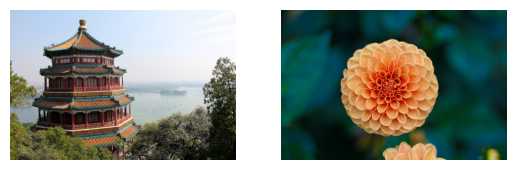

In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_sample_images
import tensorflow as tf
import numpy as np

img = load_sample_images()["images"][0]
img2 = load_sample_images()["images"][1]

plt.subplot(121)
plt.imshow(img)
plt.axis("off")

plt.subplot(122)
plt.imshow(img2)
plt.axis("off")
plt.show()

In [62]:
img2.shape

(427, 640, 3)

In [8]:
data = tf.io.encode_jpeg(img)
data2 = tf.io.encode_jpeg(img2)

example_with_image = Example(features=Features(feature=
    {
    "images": Feature(bytes_list=BytesList(value=[data.numpy(), data2.numpy()]))
    }))
serialized_example = example_with_image.SerializeToString()
with tf.io.TFRecordWriter("my_images.tfrecord") as f:
    f.write(serialized_example)

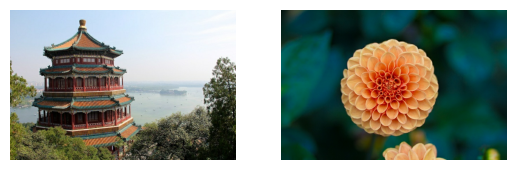

In [11]:
feature_description = {"images": tf.io.VarLenFeature(tf.string) }

def parse(serialized_example):
    example_with_image = tf.io.parse_single_example(serialized_example,
                                                    feature_description)
    return example_with_image

dataset = tf.data.TFRecordDataset(["my_images.tfrecord"]).map(parse)


for image in dataset:
    all_imgs =  image["images"].values
    plt.subplot(121)

    img1 =  tf.io.decode_image(all_imgs[0])
    plt.imshow(img1)
    plt.axis("off")

    plt.subplot(122)
    img2 =  tf.io.decode_image(all_imgs[1])
    plt.imshow(img2)
    plt.axis("off")
    plt.show()

In [66]:
# 张量序列化 + 解析
tensor = tf.constant([[0., 1.], [2., 3.], [4., 5.]])
serialized = tf.io.serialize_tensor(tensor)
serialized

tf.io.parse_tensor(serialized, out_type=tf.float32)

sparse_tensor = parsed_example["emails"]
serialized_sparse = tf.io.serialize_sparse(sparse_tensor)
serialized_sparse

BytesList(value=serialized_sparse.numpy())

value: "\010\t\022\010\022\002\010\002\022\002\010\001\"\020\000\000\000\000\000\000\000\000\001\000\000\000\000\000\000\000"
value: "\010\007\022\004\022\002\010\002\"\020\007\007a@b.comc@d.com"
value: "\010\t\022\004\022\002\010\001\"\010\002\000\000\000\000\000\000\000"

### 使用SequenceExample protobuf处理

Example protobuf非常灵活，因此它可能足以满足大多数用例。但是，当处理列表的列表时，使用它可能有些麻烦。例如，假设要对文本文档进行分类，每个文档可以被表示为句子的列表，其中每个句子被表示为单词的列表。也许每个文档也都有一个注释列表，其中每个注释都表示为单词的列表。也可能有一些上下文数据，例如文档的作者、标题和出版日期。TensorFlow的SequenceExample protobuf是针对此类用例设计的。

以下是SequenceExample protobuf的定义：
```proto
syntax = "proto3";

message FeatureList { repeated Feature feature = 1; };
message FeatureLists { map<string, FeatureList> feature_list = 1; };
message SequenceExample {
    Features context = 1;
    FeatureLists feature_lists = 2;
};

```

SequenceExample包含一个用于上下文数据的Features对象，以及一个FeatureLists对象［包含一个或多个命名的FeatureList对象（一个名为"content"，另一个名为"comments"）］。每个FeatureList包含一个Feature对象的列表，每个对象可以是一个字节字符串列表、一个64位整数列表或一个浮点数列表（在本示例中，每个Feature代表一个句子或一个注释，可能以单词标识符列表的形式存在）。构建SequenceExample并对其进行序列化和解析的过程与Example的构建、序列化和解析过程相似，但是必须使用tf.io.parse_single_sequence_example()解析单个SequenceExample或者使用tf.io.parse_sequence_example()来批量解析。这两个函数都返回一个包含上下文特征（作为字典）和特征列表（也作为字典）的元组。如果特征列表包含大小不同的序列，则可能需要使用tf.RaggedTensor.from_sparse()将它们转换为不规则的张量


In [12]:
from tensorflow.train import FeatureList, FeatureLists, SequenceExample

context = Features(feature={
    "author_id": Feature(int64_list=Int64List(value=[123])),
    "title": Feature(bytes_list=BytesList(value=[b"A", b"desert", b"place", b"."])),
    "pub_date": Feature(int64_list=Int64List(value=[1623, 12, 25]))
})

content = [["When", "shall", "we", "three", "meet", "again", "?"],
           ["In", "thunder", ",", "lightning", ",", "or", "in", "rain", "?"]]

comments = [["When", "the", "hurlyburly", "'s", "done", "."],
            ["When", "the", "battle", "'s", "lost", "and", "won", "."]]

def words_to_feature(words):
    return Feature(bytes_list=BytesList(value=[word.encode("utf-8")
                                               for word in words]))

content_features = [words_to_feature(sentence) for sentence in content]
comments_features = [words_to_feature(comment) for comment in comments]

sequence_example = SequenceExample(
    context=context,
    feature_lists=FeatureLists(feature_list={
        "content": FeatureList(feature=content_features),
        "comments": FeatureList(feature=comments_features)
    }))

In [13]:
sequence_example

context {
  feature {
    key: "title"
    value {
      bytes_list {
        value: "A"
        value: "desert"
        value: "place"
        value: "."
      }
    }
  }
  feature {
    key: "pub_date"
    value {
      int64_list {
        value: 1623
        value: 12
        value: 25
      }
    }
  }
  feature {
    key: "author_id"
    value {
      int64_list {
        value: 123
      }
    }
  }
}
feature_lists {
  feature_list {
    key: "content"
    value {
      feature {
        bytes_list {
          value: "When"
          value: "shall"
          value: "we"
          value: "three"
          value: "meet"
          value: "again"
          value: "?"
        }
      }
      feature {
        bytes_list {
          value: "In"
          value: "thunder"
          value: ","
          value: "lightning"
          value: ","
          value: "or"
          value: "in"
          value: "rain"
          value: "?"
        }
      }
    }
  }
  feature_list {
    key: "c

In [14]:
serialized_sequence_example = sequence_example.SerializeToString()

In [15]:
context_feature_descriptions = {
    "author_id": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "title": tf.io.VarLenFeature(tf.string),
    "pub_date": tf.io.FixedLenFeature([3], tf.int64, default_value=[0, 0, 0]),
}
sequence_feature_descriptions = {
    "content": tf.io.VarLenFeature(tf.string),
    "comments": tf.io.VarLenFeature(tf.string),
}

In [17]:
parsed_context, parsed_feature_lists = tf.io.parse_single_sequence_example(
    serialized_sequence_example, context_feature_descriptions,
    sequence_feature_descriptions)

parsed_context, parsed_feature_lists
parsed_content = tf.RaggedTensor.from_sparse(parsed_feature_lists["content"])
parsed_content

<tf.RaggedTensor [[b'When', b'shall', b'we', b'three', b'meet', b'again', b'?'],
 [b'In', b'thunder', b',', b'lightning', b',', b'or', b'in', b'rain', b'?']]>

In [72]:
parsed_context

{'title': SparseTensor(indices=tf.Tensor(
 [[0]
  [1]
  [2]
  [3]], shape=(4, 1), dtype=int64), values=tf.Tensor([b'A' b'desert' b'place' b'.'], shape=(4,), dtype=string), dense_shape=tf.Tensor([4], shape=(1,), dtype=int64)),
 'author_id': <tf.Tensor: shape=(), dtype=int64, numpy=123>,
 'pub_date': <tf.Tensor: shape=(3,), dtype=int64, numpy=array([1623,   12,   25], dtype=int64)>}

In [73]:
parsed_context["title"].values

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'A', b'desert', b'place', b'.'], dtype=object)>

In [74]:
parsed_feature_lists

{'comments': SparseTensor(indices=tf.Tensor(
 [[0 0]
  [0 1]
  [0 2]
  [0 3]
  [0 4]
  [0 5]
  [1 0]
  [1 1]
  [1 2]
  [1 3]
  [1 4]
  [1 5]
  [1 6]
  [1 7]], shape=(14, 2), dtype=int64), values=tf.Tensor(
 [b'When' b'the' b'hurlyburly' b"'s" b'done' b'.' b'When' b'the' b'battle'
  b"'s" b'lost' b'and' b'won' b'.'], shape=(14,), dtype=string), dense_shape=tf.Tensor([2 8], shape=(2,), dtype=int64)),
 'content': SparseTensor(indices=tf.Tensor(
 [[0 0]
  [0 1]
  [0 2]
  [0 3]
  [0 4]
  [0 5]
  [0 6]
  [1 0]
  [1 1]
  [1 2]
  [1 3]
  [1 4]
  [1 5]
  [1 6]
  [1 7]
  [1 8]], shape=(16, 2), dtype=int64), values=tf.Tensor(
 [b'When' b'shall' b'we' b'three' b'meet' b'again' b'?' b'In' b'thunder'
  b',' b'lightning' b',' b'or' b'in' b'rain' b'?'], shape=(16,), dtype=string), dense_shape=tf.Tensor([2 9], shape=(2,), dtype=int64))}

In [75]:
print(tf.RaggedTensor.from_sparse(parsed_feature_lists["content"]))

<tf.RaggedTensor [[b'When', b'shall', b'we', b'three', b'meet', b'again', b'?'],
 [b'In', b'thunder', b',', b'lightning', b',', b'or', b'in', b'rain', b'?']]>


## Keras预处理层

为神经网络准备数据通常需要对数值特征进行归一化，对分类特征和文本进行编码，裁剪和调整图像大小等。有几种选择：
- 预处理可以在准备训练数据文件时提前完成，使用任何工具，例如NumPy、Pandas或Scikit-Learn。需要在生产环境中应用完全相同的预处理步骤，以确保生产模型接收到与训练时相似的预处理输入。
- 可以在使用tf.data加载数据时动态预处理数据，方法是使用数据集的map()方法对数据集的每个元素应用预处理函数。同样，也需要在生产环境中应用相同的预处理步骤。
- 最后一种方法是将预处理层直接包含在模型中，这样它就可以在训练期间即时预处理所有输入数据，然后在生产环境中使用相同的预处理层。剩余部分将研究最后一种方法。

Keras提供了许多可以包含在模型中的预处理层：它们可以应用于数值特征、分类特征、图像和文本。接下来介绍数值特征和分类特征，以及基本的文本预处理和图片预处理。

### 归一化层

Keras提供了一个归一化层(Normalization)，可以使用它来标准化输入特征。可以在创建层时指定每个特征的均值和方差，或者更简单地在拟合模型之前将训练集传递给层的adapt()方法，这样层就可以在训练模型之前自行测量特征均值和方差：

In [24]:
norm_layer = tf.keras.layers.Normalization()
model = tf.keras.models.Sequential([
    norm_layer,
    tf.keras.layers.Dense(1)
])
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=2e-3))

norm_layer.adapt(X_train)  # 计算每个特征的均值+方差
model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=5)

Epoch 1/5
363/363 [==============================] - 1s 2ms/step - loss: 2.5206 - val_loss: 0.8555
Epoch 2/5
363/363 [==============================] - 0s 1ms/step - loss: 0.6996 - val_loss: 0.5970
Epoch 3/5
363/363 [==============================] - 0s 1ms/step - loss: 0.5940 - val_loss: 0.5537
Epoch 4/5
363/363 [==============================] - 0s 1ms/step - loss: 0.5746 - val_loss: 0.9267
Epoch 5/5
363/363 [==============================] - 0s 1ms/step - loss: 0.5699 - val_loss: 0.5363


传递给adapt()方法的数据样本必须足够大才能代表数据集，但它不一定是完整的训练集：对于Normalization层，从训练集中随机抽取的几百个实例通常足以很好地估计特征均值和方差。

由于在模型中包含了Normalization层，因此可以将这个模型部署到生产环境中，而不必再次担心归一化：模型会处理它。这种方法完全消除了预处理不匹配的风险，当人们试图为训练环境和生产环境维护不同的预处理代码但更新一个而忘记更新另一个时，就会发生预处理不匹配的情况。然后，生产环境模型最终会收到以其不希望的方式预处理的数据。如果幸运的话，会得到一个明显的错误。否则，模型的精度就会悄悄下降。

将预处理层直接包含在模型中既好又直接，但它会减慢训练速度：事实上，由于预处理是在训练过程中即时执行的，因此每个轮次都会发生一次。最好在训练前对整个训练集一次性进行归一化。为此，可以以独立的方式使用Normalization层

In [21]:
norm_layer = tf.keras.layers.Normalization()
norm_layer.adapt(X_train)
X_train_scaled = norm_layer(X_train)
X_valid_scaled = norm_layer(X_valid)

In [23]:
# 这回训练速度应该加快
model = tf.keras.models.Sequential([tf.keras.layers.Dense(1)])
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=2e-3))
model.fit(X_train_scaled, y_train, epochs=5,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
363/363 [==============================] - 1s 2ms/step - loss: 2.6152 - val_loss: 0.7547
Epoch 2/5
363/363 [==============================] - 0s 1ms/step - loss: 0.6279 - val_loss: 0.7319
Epoch 3/5
363/363 [==============================] - 0s 1ms/step - loss: 0.5423 - val_loss: 0.4928
Epoch 4/5
363/363 [==============================] - 0s 1ms/step - loss: 0.5313 - val_loss: 0.8994
Epoch 5/5
363/363 [==============================] - 0s 1ms/step - loss: 0.5370 - val_loss: 0.5092


In [25]:
# 模型部署时，可以包装自适应后（adapt后）的Normalization层和刚刚训练的模型

final_model = tf.keras.Sequential([norm_layer, model])
X_new = X_test[:3]
y_pred = final_model(X_new)

此外，Keras预处理层与tf.data API配合得很好。例如，可以将tf.data.Dataset传递给预处理层的adapt()方法，也可以使用数据集的map()方法将Keras预处理层应用于tf.data.Dataset。例如，以下是如何将自适应(adapt后）Normalization层应用于数据集中每个批次的输入特征：


In [26]:
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(5)
dataset = dataset.map(lambda X, y: (norm_layer(X), y))
list(dataset.take(1))

[(<tf.Tensor: shape=(5, 8), dtype=float32, numpy=
  array([[-0.19397898, -1.0778134 , -0.94338703,  0.01485134,  0.02073434,
          -0.5729169 ,  0.9292575 , -1.4221283 ],
         [ 0.7519828 , -1.8688954 ,  0.40547714, -0.23327859,  1.8614666 ,
           0.20516504, -0.91655123,  1.0966992 ],
         [-0.4146912 ,  0.02970134,  0.8180874 ,  1.0567816 , -0.08786613,
          -0.29983333,  1.3087244 , -1.6970019 ],
         [ 1.7188952 , -1.315138  ,  0.3266428 , -0.21955286, -0.337921  ,
          -0.11146676, -0.982138  ,  0.94177264],
         [-0.96207213, -1.2360299 , -0.05625897, -0.03124575,  1.709061  ,
          -0.3025704 , -0.8041154 ,  1.3265917 ]], dtype=float32)>,
  <tf.Tensor: shape=(5, 1), dtype=float64, numpy=
  array([[1.442],
         [1.687],
         [1.621],
         [2.621],
         [0.956]])>)]

In [27]:
# 也可以随时编写自定义的层  来做预处理
class MyNormalization(tf.keras.layers.Layer):
    def adapt(self, X):
        self.mean_ = np.mean(X, axis=0, keepdims=True)
        self.std_ = np.std(X, axis=0, keepdims=True)

    def call(self, inputs):
        eps = tf.keras.backend.epsilon()  # 获取很小的epsilon
        return (inputs - self.mean_) / (self.std_ + eps)


my_norm_layer = MyNormalization()
my_norm_layer.adapt(X_train)
X_train_scaled = my_norm_layer(X_train)

### 离散化层

离散化层的目标是通过将值范围（称为bin）映射到类别来将数值特征转换为分类特征。这有时对于具有多峰分布的特征或与目标具有高度非线性关系的特征很有用。例如，以下代码将一个数值特征age映射到三个类别［小于18岁、18～50岁（不包括）和50岁及以上］：

In [28]:
age = tf.constant([[10.],
                   [93.],
                   [57.],
                   [18.],
                   [37.],
                   [5.]])

discretize_layer = tf.keras.layers.Discretization(bin_boundaries=[18., 50.])
age_categories = discretize_layer(age)
age_categories

<tf.Tensor: shape=(6, 1), dtype=int64, numpy=
array([[0],
       [2],
       [2],
       [1],
       [1],
       [0]], dtype=int64)>

In [29]:
discretize_layer = tf.keras.layers.Discretization(num_bins=3) # 改为提供所需的bin数量，然后调用层的adapt()方法，根据值的百分位数找到合适的边界。 bins=3， -> 0 33 66 1
discretize_layer.adapt(age)
age_categories = discretize_layer(age)
age_categories

<tf.Tensor: shape=(6, 1), dtype=int64, numpy=
array([[1],
       [2],
       [2],
       [1],
       [2],
       [0]], dtype=int64)>

### 类别编码层

In [30]:
onehot_layer = tf.keras.layers.CategoryEncoding(num_tokens=3)
onehot_layer(age_categories)

<tf.Tensor: shape=(6, 3), dtype=float32, numpy=
array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)>

In [38]:
# 一次对多个分类特征进行编码:输出张量为任何输入特征中存在的每个类别中包含一个1 (多热编码)

# [1 1 0]
# [0 0 1]
# [1 0 1]
two_age_categories = np.array([[1, 1],
                               [2,2],
                               [2,1]])
onehot_layer(two_age_categories)

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 2., 0.],
       [0., 0., 2.],
       [0., 1., 1.]], dtype=float32)>

In [39]:
# 想了解每个类别的出现次数,可以在创建CategoryEncoding层设置output_mode = "count"
onehot_layer = tf.keras.layers.CategoryEncoding(num_tokens=3, output_mode="count")  # 计数编码
onehot_layer(two_age_categories)

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 2., 0.],
       [0., 0., 2.],
       [0., 1., 1.]], dtype=float32)>

In [41]:
# 不知道类别是来自第几个分类, 多热编码和计数编码都会丢失信息([0,1]和[1,0]都被编码成[1.,1.,0.]

onehot_layer = tf.keras.layers.CategoryEncoding(num_tokens=3 + 3)
onehot_layer(two_age_categories + [0, 3])  # 给第二个分类+3,调整类别标识符使它们不重叠

<tf.Tensor: shape=(3, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 1.],
       [0., 0., 1., 0., 1., 0.]], dtype=float32)>

In [42]:
onehot_layer = tf.keras.layers.CategoryEncoding(num_tokens=3,
                                                output_mode="one_hot")
tf.keras.layers.concatenate([onehot_layer(cat)
                             for cat in tf.transpose(two_age_categories)])

<tf.Tensor: shape=(3, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 1.],
       [0., 0., 1., 0., 1., 0.]], dtype=float32)>

In [44]:
tf.keras.layers.Flatten()(tf.one_hot(two_age_categories, depth=3))

<tf.Tensor: shape=(3, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 1.],
       [0., 0., 1., 0., 1., 0.]], dtype=float32)>

### StringLookup层

In [49]:
# 用于分类文本特征

cities = ["Auckland", "Paris", "Paris", "San Francisco"]
str_lookup_layer = tf.keras.layers.StringLookup()  # 创建StringLookup层
str_lookup_layer.adapt(cities)  # 适应数据

str_lookup_layer([["Paris"], ["Auckland"], ["Auckland"], ["Beijing"]])  # 模拟测试数据
# str_lookup_layer(cities)  # 使用该层对文本编码, 已知类别按照从最频繁出现的类别 到最不频繁出现的类别    从1开始编号

<tf.Tensor: shape=(4, 1), dtype=int64, numpy=
array([[1],
       [3],
       [3],
       [0]], dtype=int64)>

In [50]:
# 在创建StringLookup层时设置output_mode = "one_hot", 它将为每个列别输出一个独热向量,而部署一个整数
str_lookup_layer = tf.keras.layers.StringLookup(output_mode="one_hot")
str_lookup_layer.adapt(cities)
str_lookup_layer([["Paris"], ["Auckland"], ["Auckland"], ["Beijing"], ["Tianjin"]])

<tf.Tensor: shape=(5, 4), dtype=float32, numpy=
array([[0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)>

如果训练集非常大，将层调整为适应(adapt)训练集的随机子集可能会很方便。在这种情况下，层的adapt()方法可能会遗漏一些罕见的类别。默认情况下，它会将它们全部映射到类别0，使模型无法区分它们。为了降低这种风险（同时仍然只在训练集的一个子集上调整），可以将num_oov_indices设置为大于1的整数。这是要使用的词汇表外桶[out-of-vocabulary(OOV)buckets]的数量：每个未知类别将伪随机映射到OOV桶之一，使用哈希函数对OOV桶的数量取模（取余数）。这将使模型至少能够区分一些罕见的类别。例如：

In [51]:
str_lookup_layer = tf.keras.layers.StringLookup(num_oov_indices=5)
str_lookup_layer.adapt(cities)


str_lookup_layer([["Paris"], ["Auckland"], ["Foo"], ["Bar"], ["Baz"]])

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[5],
       [7],
       [4],
       [3],
       [4]], dtype=int64)>

由于有5个OOV桶，第一个已知类别的ID现在是5("Paris")。但是"Foo"、"Bar"和"Baz"是未知的，所以它们都被映射到某个OOV桶中。"Bar"有自己的专用桶（ID为3），但是"Foo"和"Baz"恰好映射到同一个桶（ID为4），因此模型无法区分它们。这称为哈希冲突。降低冲突风险的唯一方法是增加OOV桶的数量。但是，这也会增加类别的总数，一旦类别被独热编码，这将需要更多的RAM和额外的模型参数。所以，不要将这个数字增加太多。

In [52]:
# 一个用IntegerLookup层的例子:
ids = [123, 456, 789, 123,123, 456]
int_lookup_layer = tf.keras.layers.IntegerLookup()
int_lookup_layer.adapt(ids)

int_lookup_layer([[123], [456], [123], [111]])

# 1 2  1  0

<tf.Tensor: shape=(4, 1), dtype=int64, numpy=
array([[1],
       [2],
       [1],
       [0]], dtype=int64)>

### 哈希层

对于每个类别，Keras哈希层计算一个哈希值，对桶（或bin）的数量取模。映射完全是伪随机的，但跨运行和平台稳定（即相同的类别将始终映射到相同的整数，只要bin的数量不变)

In [26]:
hashing_layer = tf.keras.layers.Hashing(num_bins=10)
hashing_layer([["Paris"], ["Tokyo"], ["Auckland"], ["Montreal"]])

<tf.Tensor: shape=(4, 1), dtype=int64, numpy=
array([[0],
       [1],
       [9],
       [1]], dtype=int64)>

这个层不需要任何调整,不需要去适应(adapt)数据,在核外学习中(数据集太大无法放入内存),会很有用. 但是依然会有哈希冲突的问题: 两个不同的词映射到了相同的ID,使得模型无法区分它们.通常使用StringLookup层.

### 使用嵌入编码分类特征

嵌入是一些高维数据（例如类别或词汇表中的单词）的密集表示。如果有50000个可能的类别，则独热编码将产生50000维的稀疏向量（即主要包含零）。

相反，嵌入将是一个相对较小的密集向量，例如，只有100个维度。在深度学习中，嵌入通常被随机初始化，然后与其他模型参数一起通过梯度下降进行训练。例如，房价数据集中的"NEAR BAY"类别最初可以由一个随机向量（例如[0.131，0.890])表示，而"NEAR OCEAN"类别可能由另一个随机向量（例如[0.631，0.791]）表示。

![训练期间嵌入会逐渐改善](./images/tensorflow/p9.png)

在此示例中，使用二维嵌入，但维数是可以调整的超参数。由于这些嵌入是可训练的，它们会在训练过程中逐渐改善。由于在本例中它们代表非常类似的类别，梯度下降最终肯定会将它们推得更近，同时它倾向于将它们从"INLAND"类别的嵌入中移开.

事实上，类别表示越好，神经网络就越容易做出准确的预测，因此训练倾向于使嵌入成为有用的类别表示。这称为表示学习

Keras提供了一个Embedding层，它包装了一个嵌入矩阵：在该矩阵中，每个类别一行，每个嵌入维度一列。默认情况下，它是随机初始化的。要将类别ID转换为嵌入，Embedding层只是查找并返回对应于该类别的行

In [27]:
# 初始化一个包含5行和二维嵌入的Embedding层，并用它来编码一些类
embedding_layer = tf.keras.layers.Embedding(input_dim=5, output_dim=2)
embedding_layer(np.array([2, 4, 2]))

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[-0.0156639 ,  0.04400568],
       [ 0.02798482, -0.04213367],
       [-0.0156639 ,  0.04400568]], dtype=float32)>

Embedding层是随机初始化的，因此在模型外部将其用作独立的预处理层没有意义，除非使用预训练权重对其进行初始化

如果想嵌入一个分类文本属性，那么可以简单地连接一个StringLookup层和一个Embedding层

注意，嵌入矩阵的行数应等于词汇表的大小，即类别总数，包括已知类别加上OOV桶（默认情况下只有一个）。StringLookup类的vocabulary_size()方法可以方便地返回这个数字

In [28]:
ocean_prox = ["<1H OCEAN", "INLAND", "NEAR OCEAN", "NEAR BAY", "ISLAND"]
str_lookup_layer = tf.keras.layers.StringLookup()
str_lookup_layer.adapt(ocean_prox)
lookup_and_embed = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[], dtype=tf.string),
    str_lookup_layer,
    tf.keras.layers.Embedding(input_dim=str_lookup_layer.vocabulary_size(),
                              output_dim=2)  # 这里使用2维嵌入,嵌入通常有10--300个维度,具体取决于任务,词汇表大小和训练集大小,需要调整这个超参数
])
lookup_and_embed(np.array(["<1H OCEAN", "ISLAND", "<1H OCEAN"]))

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[-0.0274471 ,  0.00136548],
       [-0.03852878, -0.0316556 ],
       [-0.0274471 ,  0.00136548]], dtype=float32)>

In [29]:
# 搭建Keras模型:可以处理分类文本特征以及常规数值特征,并学习每个类别(以及每个OOV桶)的嵌入(embedding)

# 生成随机假数据
X_train_num = np.random.rand(10_000, 8)
X_train_cat = np.random.choice(ocean_prox, size=10_000).astype(object)
y_train = np.random.rand(10_000, 1)
X_valid_num = np.random.rand(2_000, 8)
X_valid_cat = np.random.choice(ocean_prox, size=2_000).astype(object)
y_valid = np.random.rand(2_000, 1)

num_input = tf.keras.layers.Input(shape=[8], name="num")
cat_input = tf.keras.layers.Input(shape=[], dtype=tf.string, name="cat")
cat_embeddings = lookup_and_embed(cat_input)
encoded_inputs = tf.keras.layers.concatenate([num_input, cat_embeddings])
outputs = tf.keras.layers.Dense(1)(encoded_inputs)
model = tf.keras.models.Model(inputs=[num_input, cat_input], outputs=[outputs])
model.compile(loss="mse", optimizer="sgd")
history = model.fit((X_train_num, X_train_cat), y_train, epochs=5,
                    validation_data=((X_valid_num, X_valid_cat), y_valid))

Epoch 1/5
313/313 [==============================] - 1s 1ms/step - loss: 0.2138 - val_loss: 0.1512
Epoch 2/5
313/313 [==============================] - 0s 950us/step - loss: 0.1264 - val_loss: 0.1092
Epoch 3/5
313/313 [==============================] - 0s 942us/step - loss: 0.0986 - val_loss: 0.0941
Epoch 4/5
313/313 [==============================] - 0s 950us/step - loss: 0.0886 - val_loss: 0.0888
Epoch 5/5
313/313 [==============================] - 0s 855us/step - loss: 0.0850 - val_loss: 0.0869


该模型采用两个输入：num_input（每个实例包含8个数值特征，以及cat_input（每个实例包含一个分类文本输入）。该模型使用之前创建的lookup_and_embed模型将每个海洋邻近类别编码为相应的可训练嵌入。接下来，它使用concatenate()函数连接数值输入和嵌入以生成完整的编码输入，这些输入已做好准备被提供给神经网络。此时，我们可以添加任何类型的神经网络，但为了简单起见，我们只添加一个密集输出层，然后使用刚刚定义的输入和输出创建Keras模型。接下来，编译模型并训练它，同时传递数值输入和分类输入。

由于Input层被命名为"num"和"cat"，我们也可以使用字典而不是元组将训练数据传递给fit()方法：{"num"：X_train_num，"cat"：X_train_cat}。或者，可以传递包含批次的tf.data.Dataset，每个批次表示为((X_batch_num，X_batch_cat)，y_batch)或({"num"：X_batch_num，"cat"：X_batch_cat}，y_batch)。当然，验证数据也是如此。

In [30]:
train_set = tf.data.Dataset.from_tensor_slices(
    ({"num":X_train_num, "cat":X_train_cat}, y_train)).batch(32)
valid_set = tf.data.Dataset.from_tensor_slices(
    ((X_valid_num, X_valid_cat), y_valid)).batch(32)
history = model.fit(train_set, epochs=5,
                    validation_data=valid_set)

Epoch 1/5
313/313 [==============================] - 0s 1ms/step - loss: 0.0836 - val_loss: 0.0863
Epoch 2/5
313/313 [==============================] - 0s 966us/step - loss: 0.0830 - val_loss: 0.0861
Epoch 3/5
313/313 [==============================] - 0s 859us/step - loss: 0.0827 - val_loss: 0.0859
Epoch 4/5
313/313 [==============================] - 0s 906us/step - loss: 0.0826 - val_loss: 0.0859
Epoch 5/5
313/313 [==============================] - 0s 950us/step - loss: 0.0825 - val_loss: 0.0859


#### 词嵌入

嵌入通常不仅是当前任务的有用表示，而且很多时候可以成功地重用于其他任务。最常见的示例是词嵌入（即单个单词的嵌入) 在执行自然语言处理任务时，与训练自己的词嵌入相比，重用预先训练的词嵌入通常效果更好。使用向量来表示单词的想法可以追溯到20世纪60年代，许多复杂的技术已被用来生成有用的向量，包括神经网络技术。

但是这种表示真正取得成功是在2013年，当时Google研究人员发表了一篇论文(https://arxiv.org/abs/1310.4546)， 描述了一种使用神经网络学习词嵌入的有效技术，这种技术大大优于以前的尝试。这使他们能够在非常大的文本语料库上学习嵌入：他们训练了一个神经网络来预测任何给定单词附近的单词，并获得了惊人的词嵌入。例如，同义词具有非常接近的嵌入，France、Spain和Italy等与语义相关的词最终聚类在一起。但是，这不仅与邻近性有关：词嵌入还沿着嵌入空间中有意义的轴进行组织。这是一个著名的示例：如果计算King-Man+Woman（加减这些单词的嵌入向量），则结果非常接近Queen单词的嵌入。换句话说，词嵌入编码了性别的概念！同样，你可以计算Madrid-Spain+France，其结果接近Paris，这似乎表明首都的概念也在嵌入中进行了编码。

![相似单词的词嵌入接近,词有了空间位置的概念](./images/tensorflow/p10.png)